In [1]:
import bilby
import numpy as np
from scipy.stats import norm, powerlaw
import emcee
import corner
import matplotlib.pyplot as plt
import h5py

We define the population parameters. We use the truncated mass model defined in https://arxiv.org/pdf/2111.03634 (Equation B2 page 38) 

In [2]:
m1_alpha = 3.4 
q_beta = 1.1
m_min = 5 
m_max = 87
peak_frac = 0.04
peak_mean = 34
peak_sigma = 3.6
delta_m = 4.8


In [3]:
N_samples = 100000

Define required functions

In [4]:
def S(m, m_min, delta_m):
    def f(m_, delta_m):
        return np.exp(delta_m/m_ + delta_m/(m_-delta_m))
    
    filter = (f(m-m_min, delta_m)+1) ** -1
    filter = np.where(m<m_min+delta_m, filter, 1.)
    filter = np.where(m>=m_min, filter, 0.)
    return filter
     

def p_m(m, m_min, m_max, m1_alpha, peak_mean, peak_sigma, peak_frac, delta_m):
     return peak_frac * norm.pdf(m, peak_mean, peak_sigma)*S(m, m_min, delta_m)+(1-peak_frac) * m ** (-m1_alpha) * (1 - m1_alpha) / (m_max ** (1-m1_alpha) - m_min ** (1-m1_alpha)) * np.heaviside(m-m_min, 0) * np.heaviside(m_max-m, 0)
def p_q(m1, m2, beta_q, m_min, delta_m):
    q = m2/m1
    return np.heaviside(q, 1) * np.heaviside(1-q, 0) * (1+beta_q) * q**(beta_q) * S(m2, m_min, delta_m) 

def log_p_m1m2(m1, m2, m_min, m_max, m1_alpha, peak_mean, peak_sigma, peak_frac, delta_m, q_beta):
    return np.log(p_m(m1, m_min, m_max, m1_alpha, peak_mean, peak_sigma, peak_frac, delta_m)) + np.log(p_q(m1, m2, q_beta, m_min, delta_m)) + np.log(np.heaviside(m1-m2,0))


In [5]:
def log_p(m, m_min, m_max, alpha, peak_mean, peak_sigma, peak_frac, delta_m, q_beta):
    m1 = m[0]
    m2 = m[1]
    if m[0] < m_min or m[0] > m_max or m[1] < m_min or m[1] > m_max:
        return -np.inf
    return log_p_m1m2(m1, m2, m_min, m_max, alpha, peak_mean, peak_sigma, peak_frac, delta_m, q_beta)

nsamples = N_samples * 2 # number of samples
nwalkers = 10 # number of walkers
ndim = 2 # number of dimensions
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_p, args=[m_min, m_max, m1_alpha, peak_mean, peak_sigma, peak_frac, delta_m, q_beta]) 
p0 = np.random.rand(nwalkers, ndim)*m_max
state = sampler.run_mcmc(p0, 10000)
sampler.reset()
sampler.run_mcmc(state, nsamples,progress = True)
samples = sampler.get_chain(flat=True)

/var/folders/81/zjs6tlpx55qfk26zjcjz0v8w0000gr/T/ipykernel_65274/1980663355.py:18: RuntimeWarning: divide by zero encountered in log
  return np.log(p_m(m1, m_min, m_max, m1_alpha, peak_mean, peak_sigma, peak_frac, delta_m)) + np.log(p_q(m1, m2, q_beta, m_min, delta_m)) + np.log(np.heaviside(m1-m2,0))
/opt/anaconda3/envs/bilby-dev/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/var/folders/81/zjs6tlpx55qfk26zjcjz0v8w0000gr/T/ipykernel_65274/1980663355.py:3: RuntimeWarning: overflow encountered in exp
  return np.exp(delta_m/m_ + delta_m/(m_-delta_m))
100%|██████████| 200000/200000 [01:53<00:00, 1759.43it/s]


In [6]:
m1_samples, m2_samples = samples.T
m1_samples = np.array(m1_samples[- N_samples:])
m2_samples = np.array(m2_samples[- N_samples:])


Generate Fiducial samples of geometric parameters using Bilby

In [7]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin =True)
priors['luminosity_distance'].maximum = 1000000
samples=priors.sample(size=N_samples)
ra_samples = samples['ra']
dec_samples = samples['dec']
psi_samples = samples['psi']
luminosity_distance_samples = samples['luminosity_distance']
theta_jn_samples = samples['theta_jn']
phase_samples = samples['phase']
chi_1_samples = samples['chi_1']
chi_2_samples = samples['chi_2']

19:54 bilby INFO    : Using aligned spin prior
19:54 bilby INFO    : No prior given, using default BBH priors in /Users/pbaral/Documents/Research/bilby-x-g/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [8]:
z_samples = bilby.gw.conversion.luminosity_distance_to_redshift(luminosity_distance_samples)
q_samples = bilby.gw.conversion.component_masses_to_mass_ratio(m1_samples, m2_samples)
detector_frame_chirp_mass = bilby.gw.conversion.component_masses_to_chirp_mass(m1_samples, m2_samples) * (1+z_samples)

Generate the times

In [9]:
start_time = 1918080018
end_time = 1918080018 + 365 * 24 * 60 *60
geocentric_time_samples = np.random.uniform(start_time, end_time, nsamples)

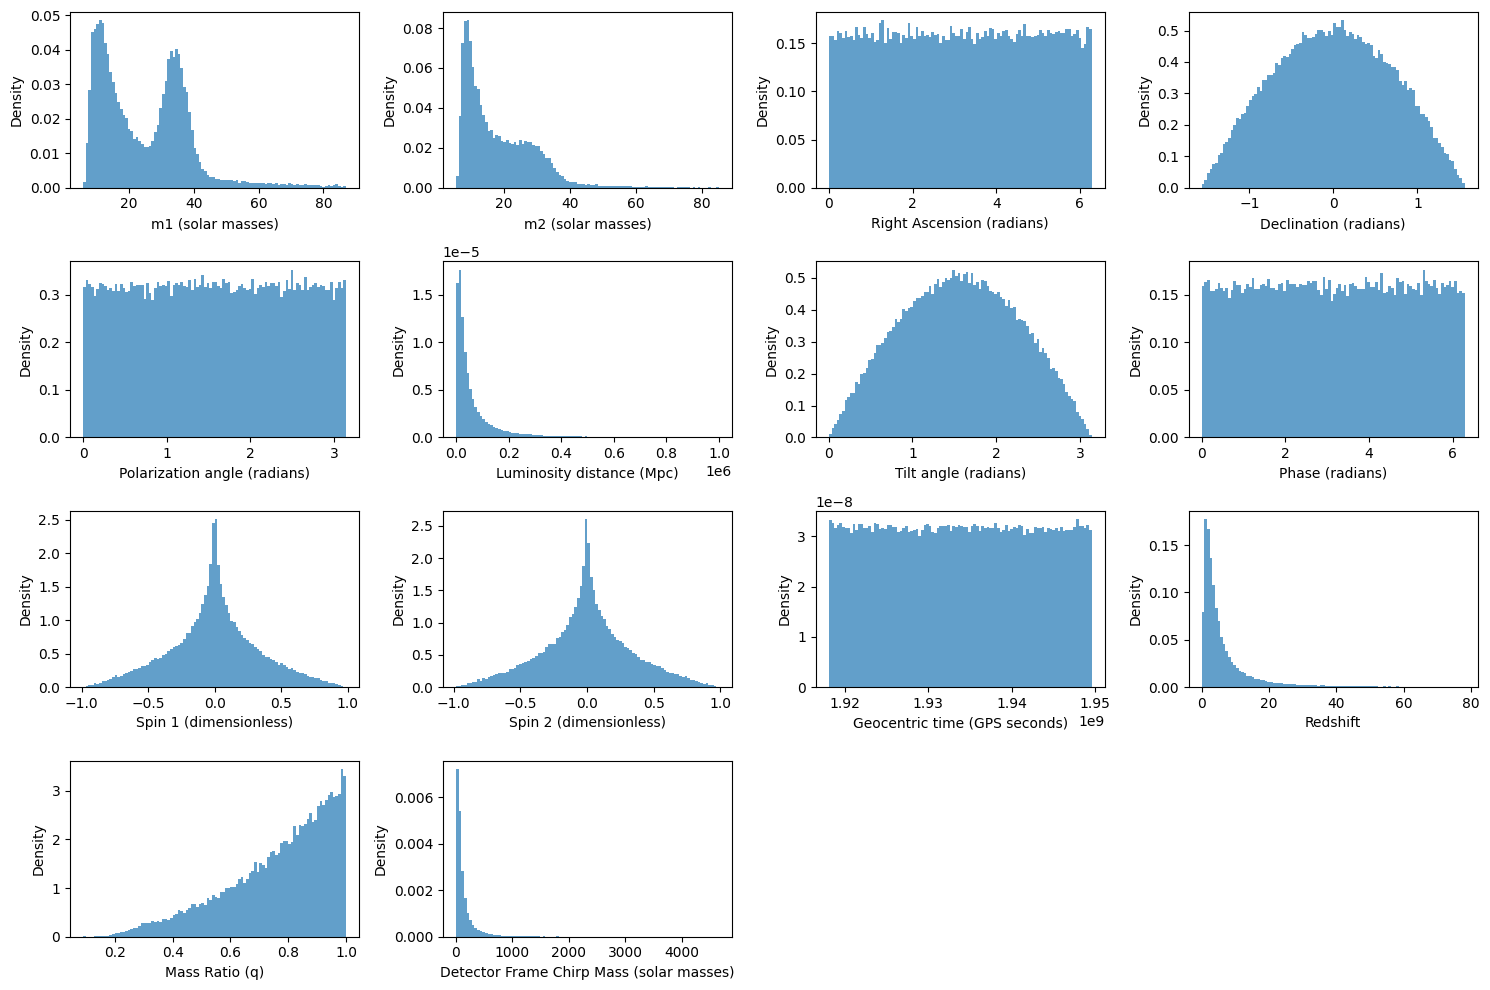

In [10]:
#Make histograms of the all 11 parameter samples
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.subplot(4, 4, 1)
plt.hist(m1_samples, bins=100, density=True, alpha=0.7, label='m1 samples')
plt.xlabel('m1 (solar masses)')
plt.ylabel('Density')
plt.subplot(4, 4, 2)
plt.hist(m2_samples, bins=100, density=True, alpha=0.7, label='m2 samples')
plt.xlabel('m2 (solar masses)')
plt.ylabel('Density')
plt.subplot(4, 4, 3)
plt.hist(ra_samples, bins=100, density=True, alpha=0.7, label='ra samples')
plt.xlabel('Right Ascension (radians)')
plt.ylabel('Density')
plt.subplot(4, 4, 4)
plt.hist(dec_samples, bins=100, density=True, alpha=0.7, label='dec samples')
plt.xlabel('Declination (radians)')
plt.ylabel('Density')
plt.subplot(4, 4, 5)
plt.hist(psi_samples, bins=100, density=True, alpha=0.7, label='psi samples')
plt.xlabel('Polarization angle (radians)')
plt.ylabel('Density')
plt.subplot(4, 4, 6)
plt.hist(luminosity_distance_samples, bins=100, density=True, alpha=0.7, label='luminosity distance samples')
plt.xlabel('Luminosity distance (Mpc)')
plt.ylabel('Density')
plt.subplot(4, 4, 7)
plt.hist(theta_jn_samples, bins=100, density=True, alpha=0.7, label='theta_jn samples')
plt.xlabel('Tilt angle (radians)')
plt.ylabel('Density')
plt.subplot(4, 4, 8)
plt.hist(phase_samples, bins=100, density=True, alpha=0.7, label='phase samples')
plt.xlabel('Phase (radians)')
plt.ylabel('Density')
plt.subplot(4, 4, 9)
plt.hist(chi_1_samples, bins=100, density=True, alpha=0.7, label='chi_1 samples')
plt.xlabel('Spin 1 (dimensionless)')
plt.ylabel('Density')
plt.subplot(4, 4, 10)
plt.hist(chi_2_samples, bins=100, density=True, alpha=0.7, label='chi_2 samples')
plt.xlabel('Spin 2 (dimensionless)')
plt.ylabel('Density')
plt.subplot(4, 4, 11)
plt.hist(geocentric_time_samples, bins=100, density=True, alpha=0.7, label='geocentric time samples')
plt.xlabel('Geocentric time (GPS seconds)')
plt.ylabel('Density')
plt.tight_layout()
plt.subplot(4, 4, 12)
plt.hist(z_samples, bins=100, density=True, alpha=0.7, label='geocentric time samples')
plt.xlabel('Redshift')
plt.ylabel('Density')
plt.tight_layout()
plt.subplot(4, 4, 13)
plt.hist(q_samples, bins=100, density=True, alpha=0.7, label='mass ratio samples')
plt.xlabel('Mass Ratio (q)')
plt.ylabel('Density')
plt.tight_layout()
plt.subplot(4, 4, 14)
plt.hist(detector_frame_chirp_mass, bins=100, density=True, alpha=0.7, label='detector frame chirp mass samples')
plt.xlabel('Detector Frame Chirp Mass (solar masses)')
plt.ylabel('Density')
plt.tight_layout()


plt.savefig('parameter_samples_histograms.png')

In [12]:
#Save the samples to a h5 file
with h5py.File('bbh_samples.h5', 'w') as f:
    f.create_dataset('m1', data=m1_samples)
    f.create_dataset('m2', data=m2_samples)
    f.create_dataset('q', data=q_samples)
    f.create_dataset('detector_frame_chirp_mass', data=detector_frame_chirp_mass)
    f.create_dataset('z', data=z_samples)
    f.create_dataset('ra', data=ra_samples)
    f.create_dataset('dec', data=dec_samples)
    f.create_dataset('psi', data=psi_samples)
    f.create_dataset('luminosity_distance', data=luminosity_distance_samples)
    f.create_dataset('theta_jn', data=theta_jn_samples)
    f.create_dataset('phase', data=phase_samples)
    f.create_dataset('chi_1', data=chi_1_samples)
    f.create_dataset('chi_2', data=chi_2_samples)
    f.create_dataset('geocentric_time', data=geocentric_time_samples)